# Time Series Forecasting using Prophet and LSTM

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# 1. Loading Data and Data preparation

In [2]:
df = pd.read_csv('Netflix Dataset.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
...,...,...,...,...,...,...,...
5535,2024-05-20,620.400024,644.369995,619.520020,640.820007,640.820007,3857900
5536,2024-05-21,636.760010,650.880005,634.219971,650.609985,650.609985,2920200
5537,2024-05-22,647.140015,649.250000,638.119995,640.469971,640.469971,2176200
5538,2024-05-23,642.340027,642.710022,630.000000,635.669983,635.669983,2313900


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


Date - Trading day timestamp

Open - Daily opening price

High - Daily maximum price

Low - Daily minimum price

Close - Daily closing price

Adj Close - Adjusted closing price (accounts for corporate actions: stock splits, dividends, and rights offerings)

Volume - Total shares traded during the session

In [4]:
df.shape

(5540, 7)

In [5]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# 2. Data Preprocessing

### 2.1. Chronological Order and Equidistant Timestamps

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

df['delta'] = df['Date'] - df['Date'].shift(1)

df[['Date', 'delta']].head()

,Date,delta
0,2002-05-23,NaT
1,2002-05-24,1 days
2,2002-05-28,4 days
3,2002-05-29,1 days
4,2002-05-30,1 days


In [7]:
df['delta'].sum(), df['delta'].count()


(Timedelta('8037 days 00:00:00'), np.int64(5539))

The data points occur at irregular intervals. We'll resample to create equally spaced timestamps, filling any gaps with the last available observation

In [8]:
df.set_index('Date', inplace=True)

date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

df_reindexed = df.reindex(date_range)

df_filled = df_reindexed.ffill()

df_filled.reset_index(inplace=True)
df_filled.rename(columns={'index': 'Date'}, inplace=True)

df_filled['delta'] = df_filled['Date'].diff()

df_filled

,Date,Open,High,Low,Close,Adj Close,Volume,delta
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0,NaT
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1 days
2,2002-05-25,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1 days
3,2002-05-26,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1 days
4,2002-05-27,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1 days
...,...,...,...,...,...,...,...,...
8033,2024-05-20,620.400024,644.369995,619.520020,640.820007,640.820007,3857900.0,1 days
8034,2024-05-21,636.760010,650.880005,634.219971,650.609985,650.609985,2920200.0,1 days
8035,2024-05-22,647.140015,649.250000,638.119995,640.469971,640.469971,2176200.0,1 days
8036,2024-05-23,642.340027,642.710022,630.000000,635.669983,635.669983,2313900.0,1 days


In [9]:
df = df_filled.copy()
df['delta'] = df['Date'] - df['Date'].shift(1)
df['delta'].sum(), df['delta'].count()

(Timedelta('8037 days 00:00:00'), np.int64(8037))

### 2.2 Handle Missings

The dataset has already been cleaned of missing values in the previous preprocessing step.

In [10]:
df = df.drop('delta', axis=1)
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# 3. Data Visualization and EDA

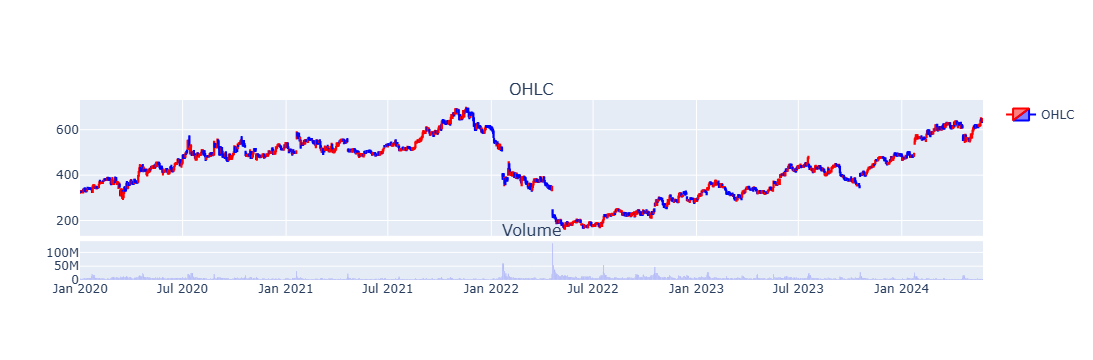

In [11]:
df_filtered = df[df['Date'] >= '2020-01-01']
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.7])
fig.add_trace(go.Candlestick(x=df_filtered["Date"], open=df_filtered["Open"], high=df_filtered["High"],
                low=df_filtered["Low"], close=df_filtered["Close"], name="OHLC",
                increasing_line_color='red',   
                decreasing_line_color='blue'),    
                row=1, col=1
)

fig.add_trace(go.Bar(x=df_filtered['Date'], y=df_filtered['Volume'], 
                showlegend=False,
                marker_color='blue'),            
                row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

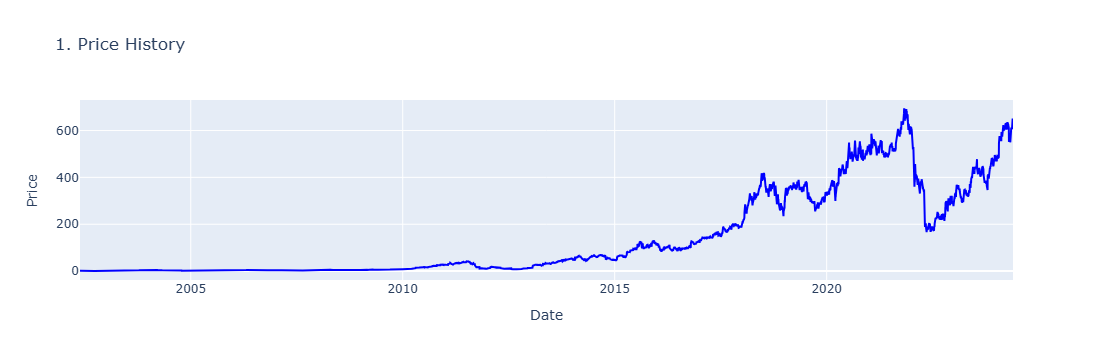

In [12]:
df['Return'] = df['Adj Close'].pct_change()
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df['Date'], y=df['Adj Close'], 
                         mode='lines', name='Price', line=dict(color='blue')))
fig1.update_layout(title='1. Price History', xaxis_title='Date', yaxis_title='Price')
fig1.show()

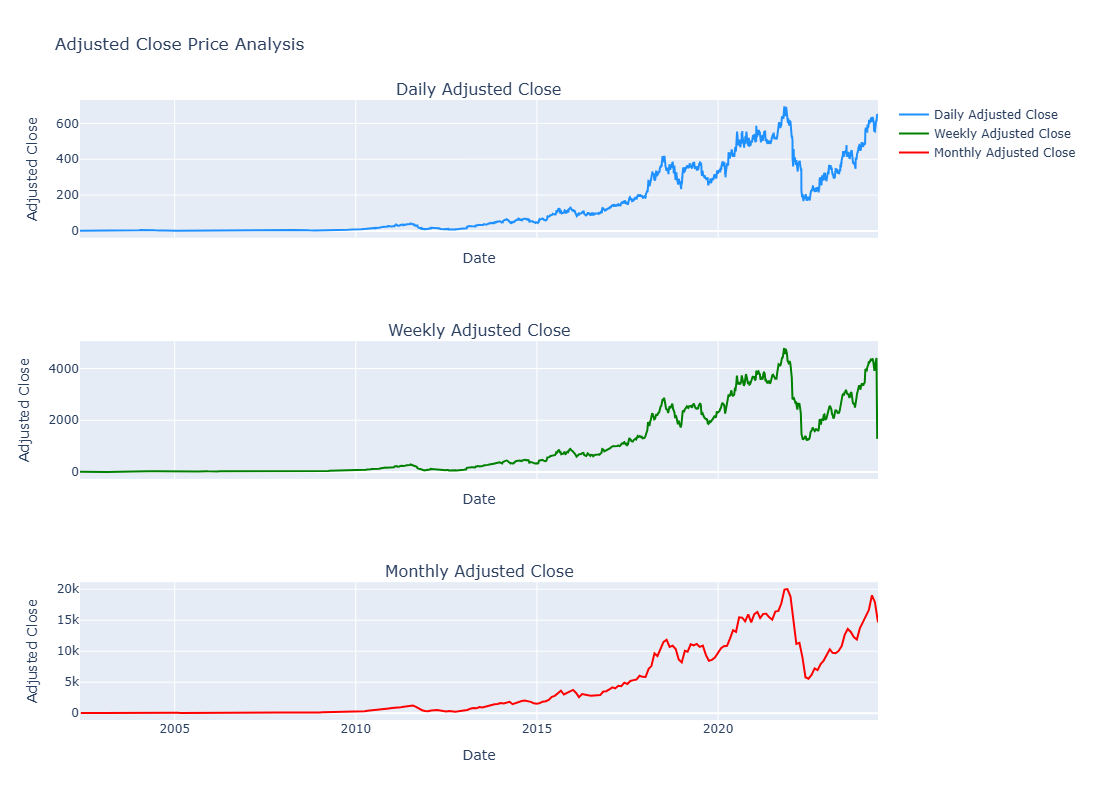

In [13]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=[
    'Daily Adjusted Close',
    'Weekly Adjusted Close',
    'Monthly Adjusted Close'
])

fig.add_trace(go.Scatter(x=df['Date'], y=df['Adj Close'], mode='lines', name='Daily Adjusted Close', line=dict(color='dodgerblue')), row=1, col=1)

resampled_df_weekly = df.resample('7D', on='Date').sum().reset_index()
fig.add_trace(go.Scatter(x=resampled_df_weekly['Date'], y=resampled_df_weekly['Adj Close'], mode='lines', name='Weekly Adjusted Close', line=dict(color='Green')), row=2, col=1)

resampled_df_monthly = df.resample('M', on='Date').sum().reset_index()
fig.add_trace(go.Scatter(x=resampled_df_monthly['Date'], y=resampled_df_monthly['Adj Close'], mode='lines', name='Monthly Adjusted Close', line=dict(color='Red')), row=3, col=1)

fig.update_layout(height=800, width=900, title_text="Adjusted Close Price Analysis")
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Adjusted Close')

fig.show()


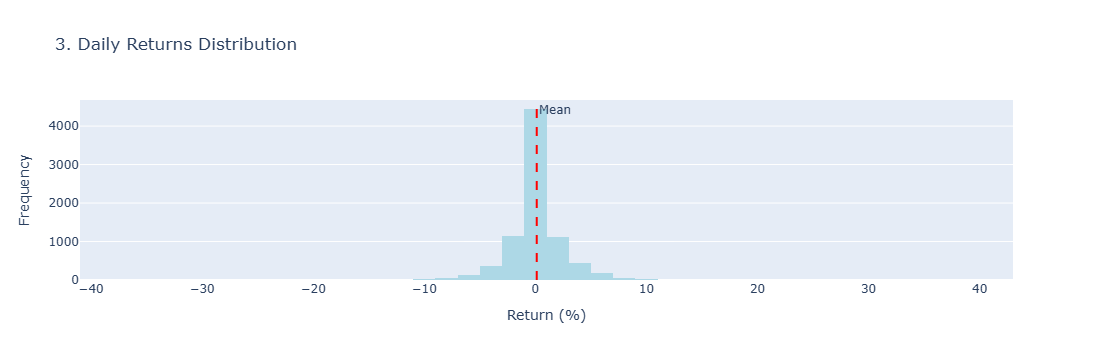

In [14]:
fig3 = go.Figure()
fig3.add_trace(go.Histogram(x=df['Return'].dropna()*100, 
                           nbinsx=50, 
                           marker_color='lightblue',
                           name='Returns'))
fig3.add_vline(x=df['Return'].mean()*100, line_dash="dash", 
               line_color="red", annotation_text="Mean")
fig3.update_layout(title='3. Daily Returns Distribution', 
                  xaxis_title='Return (%)', yaxis_title='Frequency')
fig3.show()

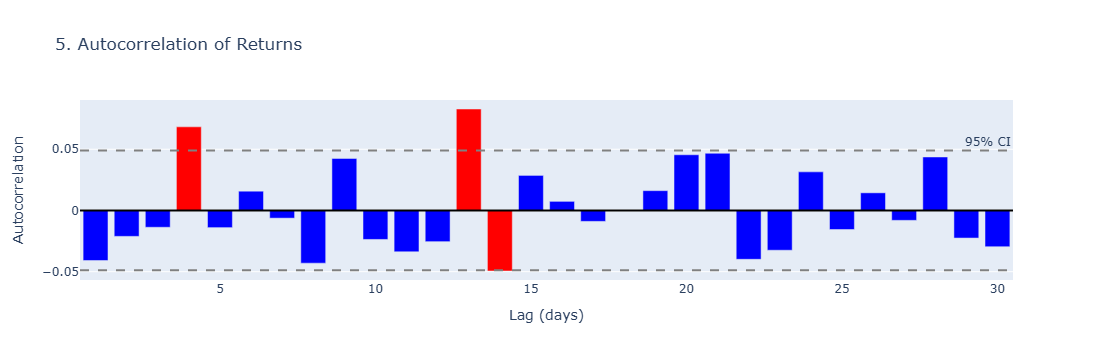

<Figure size 1200x600 with 0 Axes>

In [26]:
plt.figure(figsize=(12, 6))
lags = 30
acf_values = []
for lag in range(1, lags+1):
    autocorr = df['Return'].autocorr(lag=lag)
    acf_values.append(autocorr)

fig5 = go.Figure()
fig5.add_trace(go.Bar(x=list(range(1, lags+1)), y=acf_values,
                     marker_color=['red' if abs(val) > 1.96/np.sqrt(len(df)) else 'blue' 
                                  for val in acf_values],
                     name='Autocorrelation'))
fig5.add_hline(y=1.96/np.sqrt(len(df)), line_dash="dash", 
               line_color="gray", annotation_text="95% CI")
fig5.add_hline(y=-1.96/np.sqrt(len(df)), line_dash="dash", 
               line_color="gray")
fig5.add_hline(y=0, line_color="black")

fig5.update_layout(title='5. Autocorrelation of Returns', 
                  xaxis_title='Lag (days)', 
                  yaxis_title='Autocorrelation',
                  showlegend=False)
fig5.show()

In [16]:
df['Date_numeric'] = range(len(df)) 
df['Trend'] = df['Adj Close'].rolling(window=30, center=True).mean()
df['Detrended'] = df['Adj Close'] - df['Trend']
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Detrended'].mean()
df['Seasonal'] = df['Month'].map(monthly_avg)

df['Residual'] = df['Detrended'] - df['Seasonal']

fig8 = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'],
    vertical_spacing=0.08
)

fig8.add_trace(
    go.Scatter(x=df['Date'], y=df['Adj Close'], 
               mode='lines', line=dict(color='blue', width=2)),
    row=1, col=1
)

fig8.add_trace(
    go.Scatter(x=df['Date'], y=df['Trend'], 
               mode='lines', line=dict(color='red', width=2)),
    row=2, col=1
)

fig8.add_trace(
    go.Scatter(x=df['Date'], y=df['Seasonal'], 
               mode='lines', line=dict(color='green', width=2)),
    row=3, col=1
)

fig8.add_trace(
    go.Scatter(x=df['Date'], y=df['Residual'], 
               mode='lines', line=dict(color='purple', width=2)),
    row=4, col=1
)

fig8.add_hline(y=0, line_dash="dash", line_color="gray", row=3, col=1)
fig8.add_hline(y=0, line_dash="dash", line_color="gray", row=4, col=1)

fig8.update_layout(height=800, showlegend=False)
fig8.update_yaxes(title_text="Price", row=1, col=1)
fig8.update_yaxes(title_text="Trend", row=2, col=1)
fig8.update_yaxes(title_text="Seasonal", row=3, col=1)
fig8.update_yaxes(title_text="Residual", row=4, col=1)
fig8.update_xaxes(title_text="Date", row=4, col=1)

fig8.show()

# 4. Modeling

We will forecast using both Prophet and LSTM models and compare their performance.

### 4.1. Prophet

DEBUG	Task(Task-7) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-7) cmdstanpy:model.py:__init__()- Adding TBB (C:\Users\63995\anaconda3\Lib\site-packages\prophet\stan_model\cmdstan-2.37.0\stan\lib\stan_math\lib\tbb) to PATH
INFO	Task(Task-7) prophet:forecaster.py:parse_seasonality_args()- Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG	Task(Task-7) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\63995\AppData\Local\Temp\tmp17wgvib1\w_gqa4tk.json
DEBUG	Task(Task-7) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\63995\AppData\Local\Temp\tmp17wgvib1\x5vv8m59.json
DEBUG	Task(Task-7) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-7) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-7) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['C:\\Users\\63995\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bi

MAE: 95.8279237651335
RMSE: 110.77584699545409


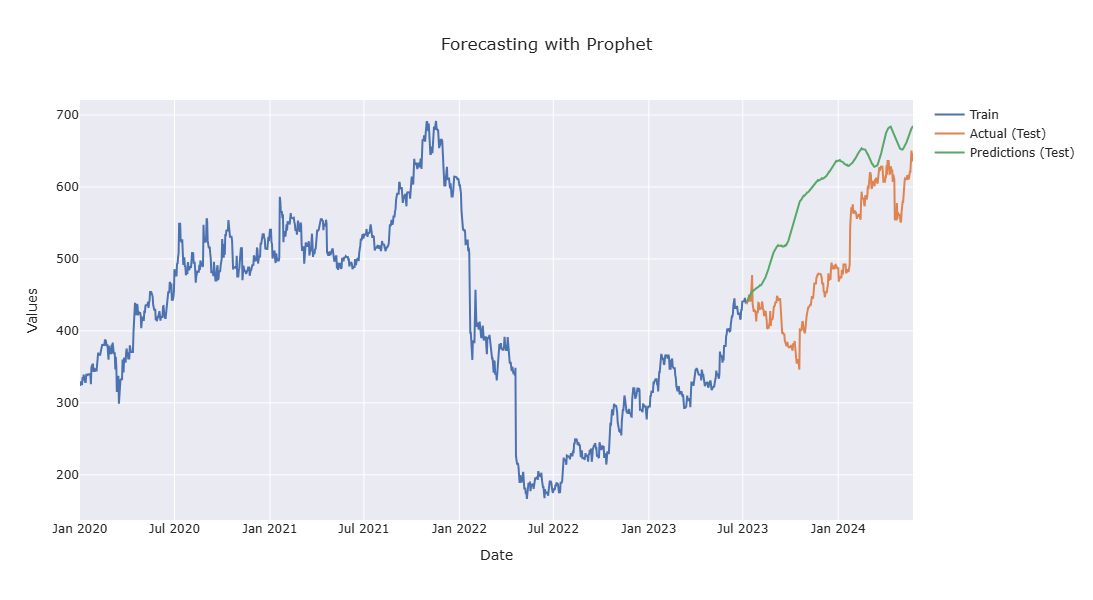

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from prophet import Prophet

df = df[df['Date'] >= '2020-01-01']

train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

train = train.rename(columns={'Date': 'ds', 'Close': 'y'})
test = test.rename(columns={'Date': 'ds', 'Close': 'y'})

model1 = Prophet()
model1.fit(train)

future = model1.make_future_dataframe(periods=len(test), freq='D')
forecast = model1.predict(future)

forecast_test = forecast[-len(test):]

comparison = test.copy()
comparison['Predicted'] = forecast_test['yhat'].values

mae = np.mean(np.abs(comparison['y'] - comparison['Predicted']))
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['Predicted']))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


fig = go.Figure()

fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Actual (Test)'))
fig.add_trace(go.Scatter(x=test['ds'], y=comparison['Predicted'], mode='lines', name='Predictions (Test)'))

fig.update_layout(
    title='Forecasting with Prophet',
    xaxis_title='Date',
    yaxis_title='Values',
    template='seaborn',
    width=900, height=600
)

fig.show()

The forecasting plot shows that the Prophet model generally captures the upward direction of the price during the test period, as the predicted values follow the overall increasing trend. However, the predictions are smoother than the actual test data and tend to slightly overestimate prices at several points. The model achieved a Mean Absolute Error (MAE) of 95.83 and a Root Mean Squared Error (RMSE) of 110.78, which indicate that, on average, the predictions differ from the actual prices by about 96 units, with larger errors being more heavily penalized by the RMSE. Overall, the model performs reasonably well in identifying the trend but is less accurate in capturing short-term fluctuations and sudden price changes.

### 4.2. LSTM

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout

model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model2.add(Dropout(0.2))
model2.add(LSTM(50))
model2.add(Dropout(0.2))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mean_squared_error')

history = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.1429 - val_loss: 0.0044
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0090 - val_loss: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0053 - val_loss: 9.0924e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0049 - val_loss: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0047 - val_loss: 8.3496e-04
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0041 - val_loss: 9.1237e-04
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0038 - val_loss: 8.7701e-04
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0040 - val_loss: 7.4094e-04
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0044 - val_loss: 7.7655e-04
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 

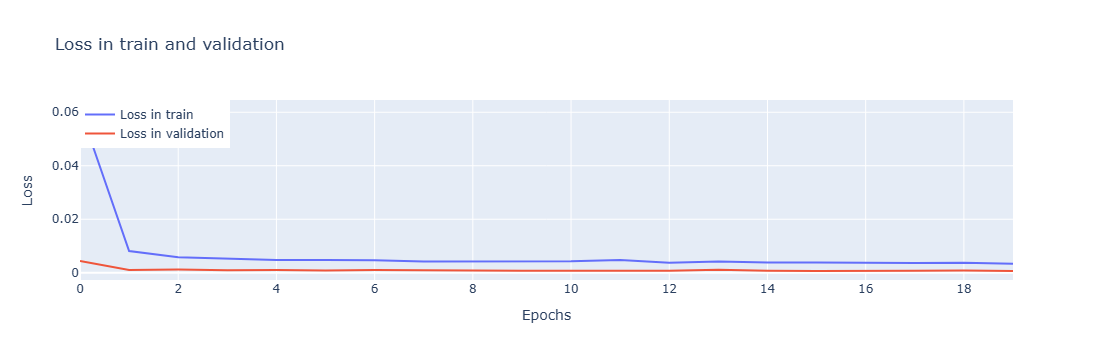

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(len(loss))),
    y=loss,
    mode='lines',
    name='Loss in train'
))

fig.add_trace(go.Scatter(
    x=list(range(len(val_loss))),
    y=val_loss,
    mode='lines',
    name='Loss in validation'
))

fig.update_layout(
    title='Loss in train and validation',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend=dict(x=0, y=1.0)
)

fig.show()

In [21]:
predictions = model2.predict(X_test)
predictions = scaler.inverse_transform(predictions)

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


MAE: 13.092236106606011
RMSE: 17.94674303717176


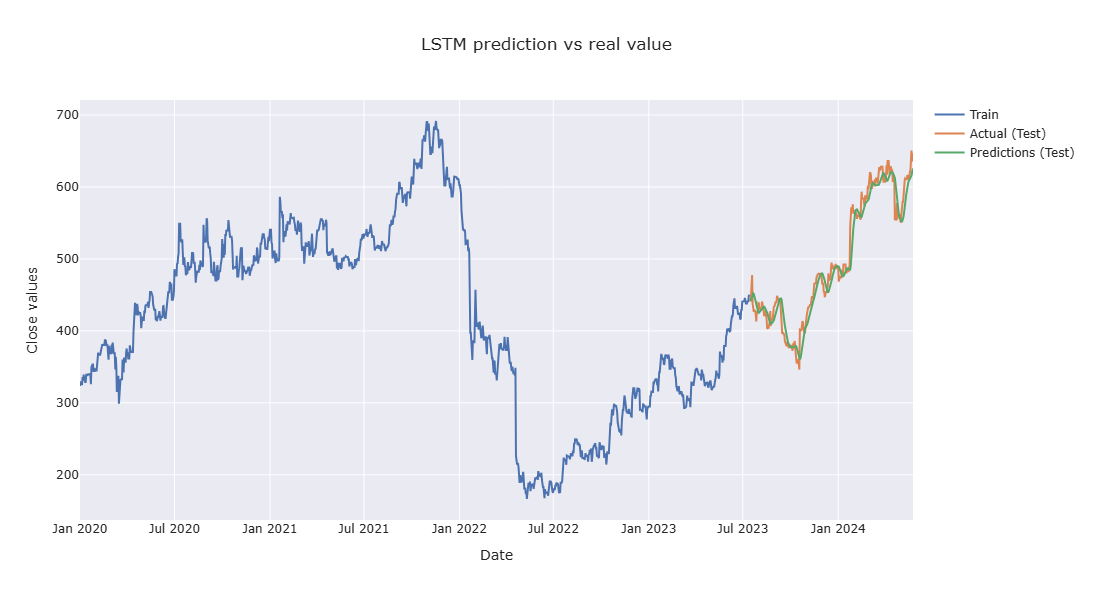

In [22]:
mae1 = np.mean(np.abs(y_test_scaled - predictions))
rmse_scaled = np.sqrt(mean_squared_error(y_test_scaled, predictions))
print(f'MAE: {mae1}')
print(f'RMSE: {rmse_scaled}')

train_dates = df['Date'][:train_size + seq_length]
test_dates = df['Date'][train_size + seq_length:]


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_dates, y=df['Close'][:train_size + seq_length], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test_dates, y=df['Close'][train_size + seq_length:], mode='lines', name='Actual (Test)'))
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name='Predictions (Test)'))

fig.update_layout(
    title='LSTM prediction vs real value',
    xaxis_title='Date',
    yaxis_title='Close values',
    template='seaborn',
    width=900, height=600
)

fig.show()

The LSTM results show that the model’s predictions closely follow the actual prices during the test period, indicating strong predictive performance. The model achieved a Mean Absolute Error (MAE) of 13.09 and a Root Mean Squared Error (RMSE) of 17.95, which are relatively low compared to the price range, showing that prediction errors are small on average. Visually, the predicted values align well with the actual test data, capturing both the upward trend and short-term fluctuations more effectively than simpler models. Overall, this suggests that the LSTM model provides accurate and reliable forecasts for the given time series.

## Comparison of Prophet and LSTM
Compared to the first model (Prophet), the LSTM model performs significantly better. The Prophet model produced a MAE of 95.83 and an RMSE of 110.78, indicating large average prediction errors and difficulty in capturing short-term price movements. In contrast, the LSTM model achieved a much lower MAE of 13.09 and RMSE of 17.95, showing that its predictions are far closer to the actual values. Visually, the Prophet forecasts are smoother and tend to overestimate the price, while the LSTM predictions closely track the real price movements and adapt better to fluctuations. Overall, the LSTM model demonstrates superior accuracy and is more suitable for this time-series forecasting task.

# 4.3 Forecast after the last date (May 24, 2024) using LSTM

In [23]:
from datetime import datetime, timedelta
last_seq = scaled_data[-seq_length:].reshape(1, seq_length, 1)
future_preds = []

forecast_end_date = datetime(2024, 12, 31).date()
last_date = pd.to_datetime(df['Date'].iloc[-1]).date()

current_date = last_date + timedelta(days=1)
days_needed = 0
future_dates = []

while current_date <= forecast_end_date:
    if current_date.weekday() < 5:
        future_dates.append(current_date)
        days_needed += 1
    current_date += timedelta(days=1)
for i in range(days_needed):

    pred = model2.predict(last_seq, batch_size=1)[0, 0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[[pred]]], axis=1)
future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

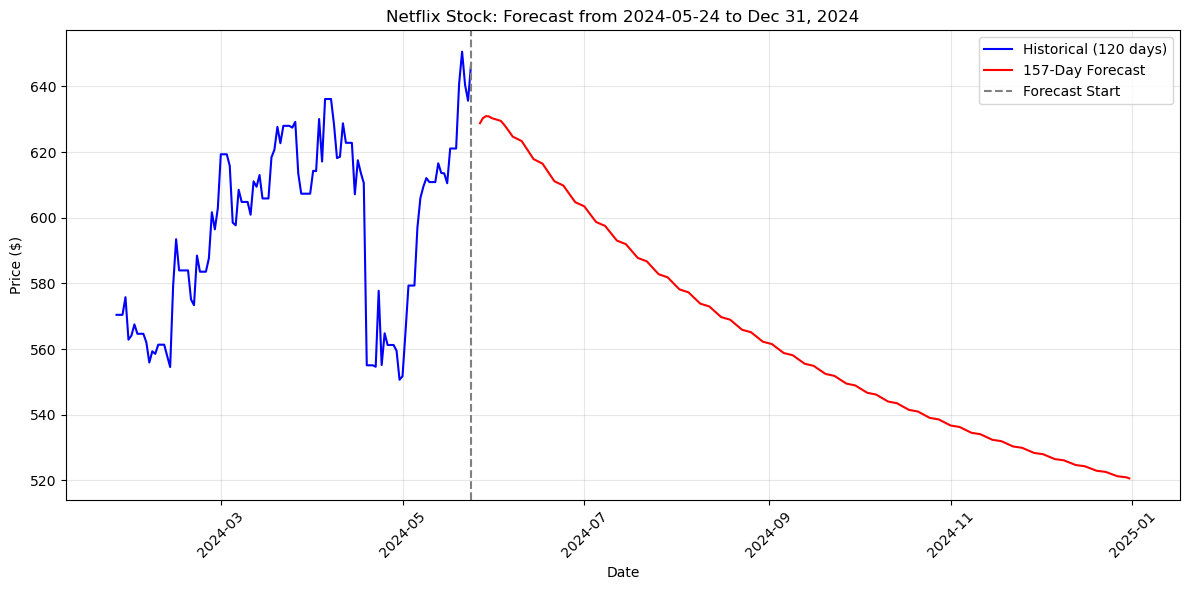


Last price (2024-05-24): $646.75
Day 1 forecast: $628.81
Final forecast (Dec 31, 2024): $520.58


In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-120:], df['Close'][-120:], 'b-', label='Historical (120 days)')
plt.plot(future_dates, future_prices, 'r-', label=f'{days_needed}-Day Forecast')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title(f'Netflix Stock: Forecast from {last_date} to Dec 31, 2024')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nLast price ({last_date}): ${df['Close'].iloc[-1]:.2f}")
print(f"Day 1 forecast: ${future_prices[0][0]:.2f}")
print(f"Final forecast (Dec 31, 2024): ${future_prices[-1][0]:.2f}")